In this notebook we'll show how homologies can be used to analyze neural networks.

In [1]:
import os
os.chdir('../..')

In [2]:
import copy
from pathlib import Path
from IPython.display import display
import torch
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
import torchvision.transforms as TF
from examples.CIFAR10.models import *
from eXNN.InnerNeuralTopology import NetworkHomologies

In [3]:
# prepare data
_normalize = TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
tfm = TF.Compose([TF.ToTensor(), _normalize])
train_ds = CIFAR10(root='./.cache', train=True, download=False, transform=tfm)
test_ds = CIFAR10(root='./.cache', train=False, download=False, transform=tfm)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=True)

In [4]:
train_batch = next(iter(train_dl))[0]
test_batch = next(iter(test_dl))[0]

In [5]:
# download repository https://github.com/Med-AI-Lab/eXNN-task-CIFAR10
# change model_repo to the root of the downloaded repository
model_repo = Path('../eXNN-task-CIFAR10')

In [6]:
# select cuda device
device = torch.device('cpu')

In [7]:
# homologies computation settings
layers = ["layer2", "layer4", "fc"]
hom_type = "sparse"
coefs_type = "2"

# Homology barcodes visualization

## Full model

In [8]:
svd_model = resnet18(num_classes=10)
decompose_module(svd_model, "channel")
svd_model.load_state_dict(torch.load(model_repo / "ResNet18_SVD_channel_O-100.0_H-0.000100.sd.pt",  map_location=device))
print(f"Number of parameters: {number_of_params(svd_model)}")
svd_model = svd_model.eval()

Number of parameters: 12668746


In [9]:
results_train = NetworkHomologies(svd_model, train_batch, layers=layers, hom_type=hom_type, coefs_type=coefs_type)
results_test = NetworkHomologies(svd_model, test_batch, layers=layers, hom_type=hom_type, coefs_type=coefs_type)

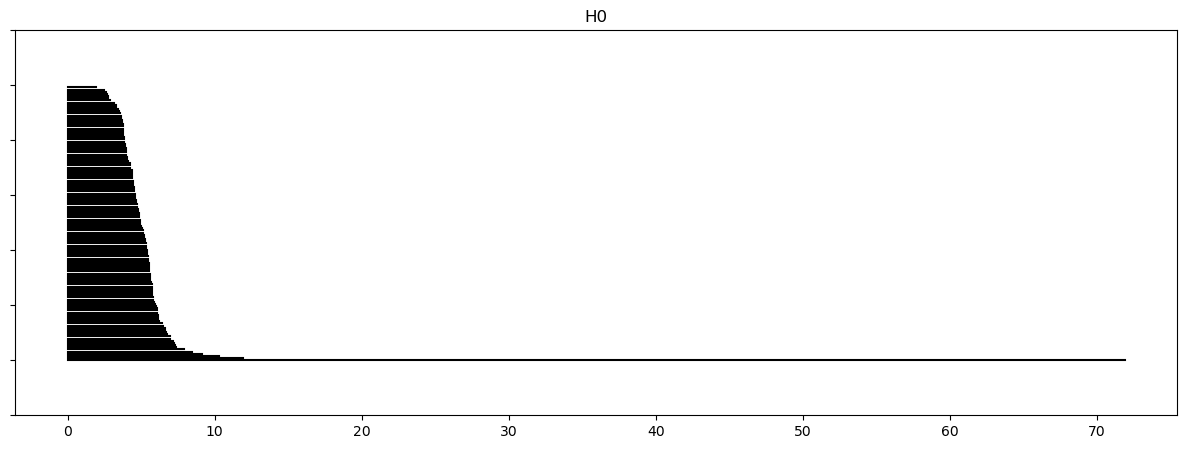

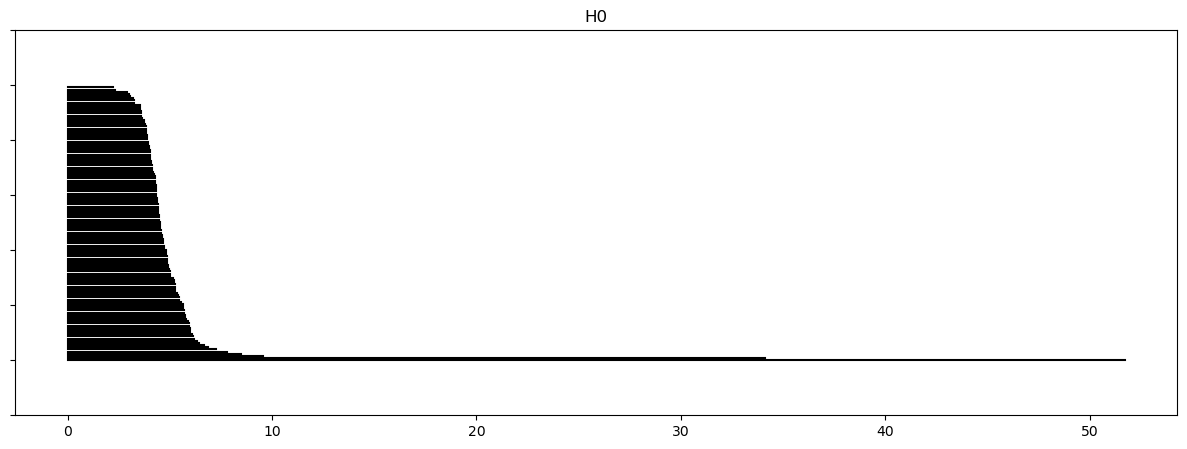

In [10]:
display(results_train["fc"], results_test["fc"])

## Pruned model

In [11]:
pruned_model = copy.deepcopy(svd_model)
prune_model(model=pruned_model, energy_threshold=0.9)
print(f"Number of parameters: {number_of_params(pruned_model)}")
pruned_model = pruned_model.eval()

Number of parameters: 7206832


In [12]:
results_train = NetworkHomologies(pruned_model, train_batch, layers=layers, hom_type=hom_type, coefs_type=coefs_type)
results_test = NetworkHomologies(pruned_model, test_batch, layers=layers, hom_type=hom_type, coefs_type=coefs_type)

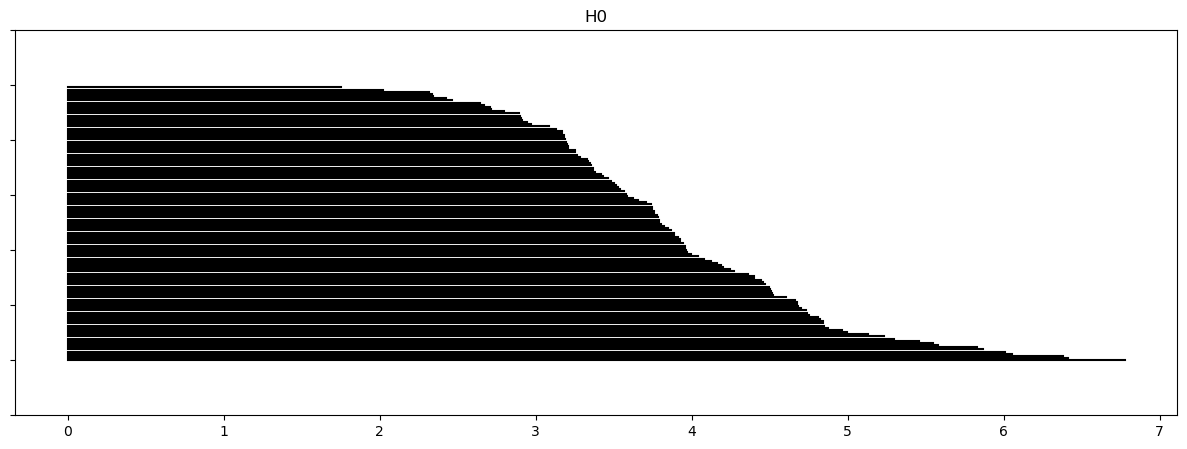

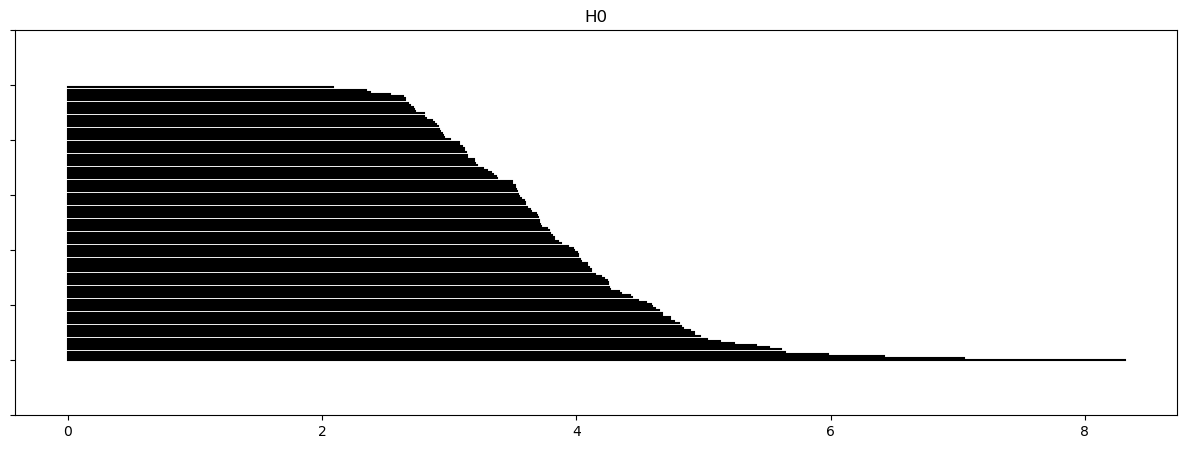

In [13]:
display(results_train["fc"], results_test["fc"])

# Analysis

So, what do the above plots show us?

Observation: full model separates the test data even better than the training data. <br/>
Why: the test data barcode is 28% longer that the training data barcode. <br/>
Implications: the model is robust, however it contains uninformative features. <br/>

Observation: pruned model separates the test data and the training data similarly well. <br/>
Why: the training data barcode is 2% longer that the test data barcode. <br/>
Implications: the model is almost as robust as the full model and it does not contain uninformative features. <br/>